In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim


In [2]:
# Cheking CUDA device availability


if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
else:
    print("CUDA is not available")
    device = torch.device("cpu")

print(device)

CUDA is available
cuda


In [3]:
data_dir = './DATABASE/Final Data/F'

batch_size = 8 

train_size, valid_size, test_size = 0.8, 0.1, 0.1

transform = transforms.Compose([transforms.Resize(314),
                                transforms.CenterCrop(299),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ])


dataset = datasets.ImageFolder(data_dir, transform=transform)

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(train_size * num_data))
split_add = int(np.floor(valid_size * num_data))

train_idx, valid_idx, test_idx = indices[:split], indices[split: split+split_add], indices[ split+split_add:]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)  # type: ignore
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)  # type: ignore
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)  # type: ignore

In [5]:
from torchvision.models import Inception_V3_Weights

model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
for param in model.parameters():
    param.requires_grad = False
    
fc = nn.Sequential(nn.Linear(2048, 1024), # inceptionv3_out = 2048
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512, 2),
                          nn.LogSoftmax(dim=1))

model.fc = fc

In [7]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [13]:
epochs = 30

train_losses, valid_losses = [], []

valid_loss_min = np.Inf
model_count = 0

for e in range(epochs):
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps[0], labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                # labels = labels - 1
                log_ps = model(images)
                valid_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(valid_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
        
        if valid_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_losses[-1]))
            torch.save(model.state_dict(), f'./Models/model_incept_{model_count}.pt')
            model_count += 1
            valid_loss_min = valid_losses[-1]

Epoch: 1/30..  Training Loss: 0.691..  Validation Loss: 0.738..  Validation Accuracy: 0.375
Validation loss decreased (inf --> 0.737649).  Saving model ...
Epoch: 2/30..  Training Loss: 0.688..  Validation Loss: 0.735..  Validation Accuracy: 0.375
Validation loss decreased (0.737649 --> 0.735255).  Saving model ...
Epoch: 3/30..  Training Loss: 0.697..  Validation Loss: 0.724..  Validation Accuracy: 0.375
Validation loss decreased (0.735255 --> 0.723725).  Saving model ...
Epoch: 4/30..  Training Loss: 0.693..  Validation Loss: 0.716..  Validation Accuracy: 0.250
Validation loss decreased (0.723725 --> 0.716395).  Saving model ...
Epoch: 5/30..  Training Loss: 0.680..  Validation Loss: 0.730..  Validation Accuracy: 0.375
Epoch: 6/30..  Training Loss: 0.699..  Validation Loss: 0.690..  Validation Accuracy: 0.500
Validation loss decreased (0.716395 --> 0.689946).  Saving model ...
Epoch: 7/30..  Training Loss: 0.672..  Validation Loss: 0.694..  Validation Accuracy: 0.375
Epoch: 8/30..  T

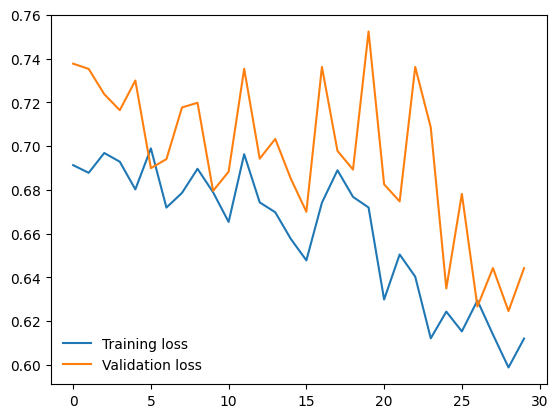

In [20]:
from torch import Tensor

val_losses = Tensor(valid_losses, device='cpu')

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [8]:
x = torch.Tensor([1, 2, 3])
x.to('cuda')

tensor([1., 2., 3.], device='cuda:0')

In [8]:
best_model = max(os.listdir('./Models/'), key=lambda x: int(x.split('_')[2].split('.')[0]))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

model.load_state_dict(torch.load(f'./Models/{best_model}'))
model.to('cpu')

img, label = next(iter(test_loader))
len(test_loader)

2

In [14]:
cls_len = 2

test_loss = 0.0
accuracy = 0
# train_on_gpu = torch.cuda.is_available()
# print(train_on_gpu)
train_on_gpu = False

model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    log_ps = model(data)
    test_loss += criterion(log_ps, target)
                
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
    
print("Test loss: {:.3f}.. \t Test Accuracy: {:.3f}".format(test_loss/len(test_loader), accuracy/len(test_loader)))


Test loss: 0.661.. 	 Test Accuracy: 0.875
